In [1]:
# load libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import warnings
warnings.filterwarnings('ignore')

from nltk.stem.snowball import SnowballStemmer
import re
import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import KFold,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,f1_score,classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NEERAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NEERAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Import Train and Test Datasets

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head(3)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0


In [3]:
test.head(3)

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...


# Exploratory Data Analysis

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
ID                      20972 non-null int64
TITLE                   20972 non-null object
ABSTRACT                20972 non-null object
Computer Science        20972 non-null int64
Physics                 20972 non-null int64
Mathematics             20972 non-null int64
Statistics              20972 non-null int64
Quantitative Biology    20972 non-null int64
Quantitative Finance    20972 non-null int64
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8989 entries, 0 to 8988
Data columns (total 3 columns):
ID          8989 non-null int64
TITLE       8989 non-null object
ABSTRACT    8989 non-null object
dtypes: int64(1), object(2)
memory usage: 210.8+ KB


### Missing Values

In [6]:
# Train data
missing_val_train = train.isnull().sum()
missing_val_train_percentage =  missing_val_train/len(train)
missing_data_train = pd.concat([missing_val_train,missing_val_train_percentage],axis=1)
missing_data_train = missing_data_train.rename(columns = {0:'Missing Values',1:'Missing Value Percentage'})
missing_data_train

,Missing Values,Missing Value Percentage
ID,0,0.0
TITLE,0,0.0
ABSTRACT,0,0.0
Computer Science,0,0.0
Physics,0,0.0
Mathematics,0,0.0
Statistics,0,0.0
Quantitative Biology,0,0.0
Quantitative Finance,0,0.0


In [7]:
# Test data
missing_val_test = test.isnull().sum()
missing_val_test_percentage =  missing_val_test/len(test)
missing_data_test = pd.concat([missing_val_test,missing_val_test_percentage],axis=1)
missing_data_test = missing_data_test.rename(columns = {0:'Missing Values',1:'Missing Value Percentage'})
missing_data_test

,Missing Values,Missing Value Percentage
ID,0,0.0
TITLE,0,0.0
ABSTRACT,0,0.0


### Calculating number of comments from abstract under each label

In [8]:
rowSums = train.iloc[:,3:].sum(axis=1)
clean_comments_count= (rowSums==0).sum(axis=0)

print(f'Total number of comments = {len(train)}')
print(f'Number of clean comments = {clean_comments_count}')
print(f'Number of comments with labels = {(len(train)-clean_comments_count)}')

Total number of comments = 20972
Number of clean comments = 0
Number of comments with labels = 20972


In [9]:
categories = list(train.columns.values)
categories = categories[3:]
print(categories)

['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']


In [10]:
# Calculating number of comments in each category
counts = []
for i in categories:
    counts.append((i,train[i].sum()))
# print(counts)

train_stats = pd.DataFrame(counts,columns=['category', 'number of comments'])
train_stats

,category,number of comments
0,Computer Science,8594
1,Physics,6013
2,Mathematics,5618
3,Statistics,5206
4,Quantitative Biology,587
5,Quantitative Finance,249


### Plotting the label wise comments abstract

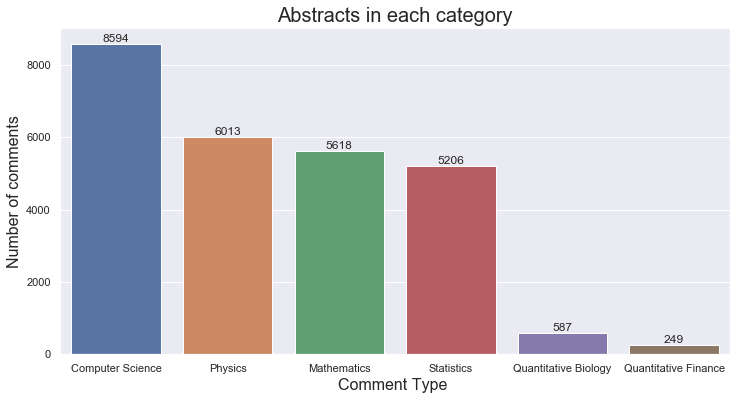

In [11]:
sns.set(font_scale = 1)
plt.figure(figsize=(12,6))

ax = sns.barplot(categories, train.iloc[:,3:].sum().values)

plt.title("Abstracts in each category", fontsize=20)
plt.ylabel('Number of comments', fontsize=16)
plt.xlabel('Comment Type ', fontsize=16)

#adding the text labels
rects = ax.patches
labels = train.iloc[:,3:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)

plt.show();

### Calculating number of comments having multiple labels

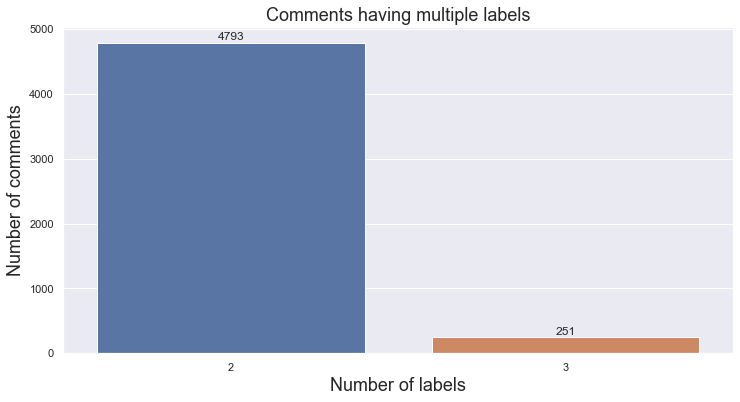

In [12]:
rowSums = train.iloc[:,3:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 1)
plt.figure(figsize=(12,6))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels", fontsize=18)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show();

# Text Data Cleaning

In [13]:
# Load stopwords, common words such as  "a," "the," "it," etc.
stop_words = stopwords.words('english')
    
#Initialize stemmer, which will take words and convert words to their "stem," e.g. Playing-> Play
ps = PorterStemmer() 

# Removes non-alphabetical characters, whitespaces, and converts all letters to lowercase
def clean_text(txt): 
    txt= txt.lower()   #lowercase
    txt= re.sub("[^a-zA-Z]"," ",txt) #Remove everything except alphabetical characters 
    txt= word_tokenize(txt) #tokenize (split into list and remove whitespace)
    
    #initialize list to store clean text
    clean_text=""
    
    #iterate over each word
    for w in txt:      
        #remove stopwords
        if w not in stop_words:
            #stem=ps.stem(w) #stem 
            stem=w
            clean_text = clean_text + stem +" " 
    return clean_text


# Train data
train['TITLE']=train['TITLE'].apply(clean_text)
train['ABSTRACT']=train['ABSTRACT'].apply(clean_text)

# Test data
test['TITLE']=test['TITLE'].apply(clean_text)
test['ABSTRACT']=test['ABSTRACT'].apply(clean_text)

# Combining both features
train['combine']=train['TITLE']+train['ABSTRACT']
test['combine']=test['TITLE']+test['ABSTRACT']

### WordCloud representation of most used words in each category of comments

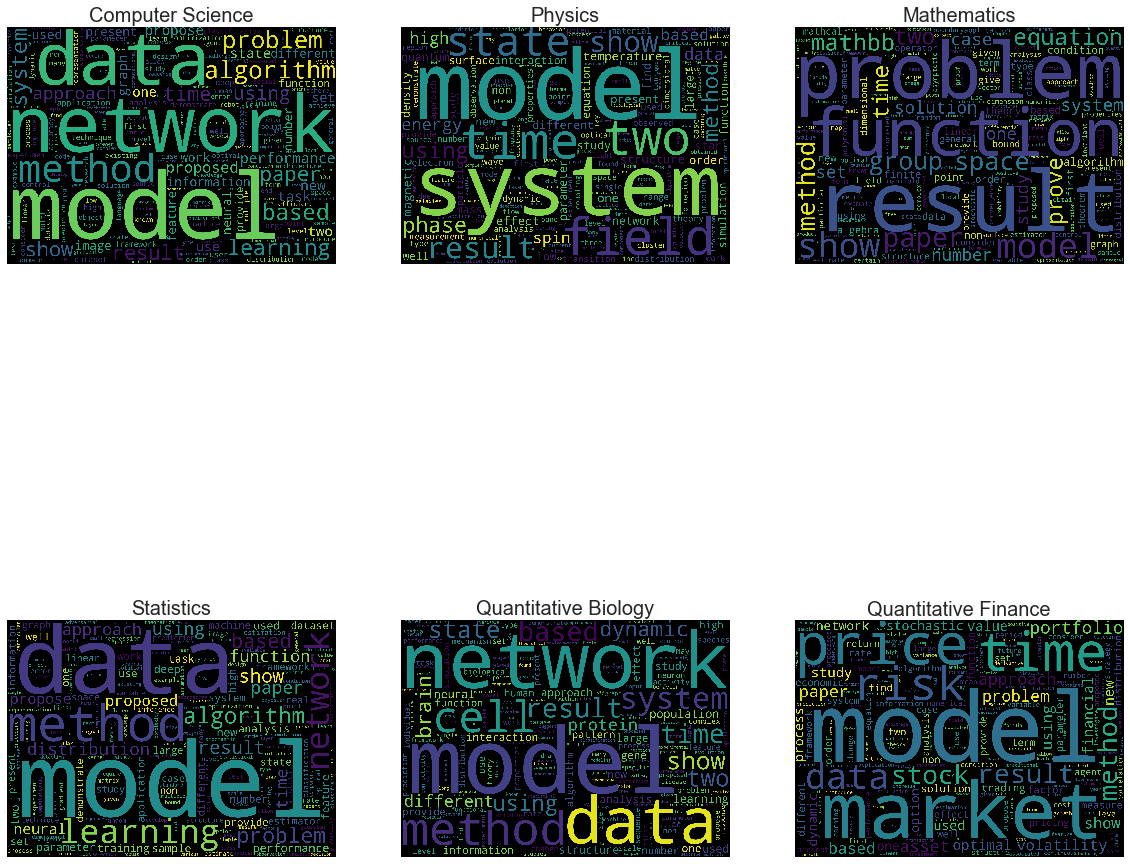

In [14]:
plt.figure(figsize=(20,20))

# Computer Science
subset = train[train['Computer Science']==1]

text = subset.ABSTRACT.values

cloud_computer_science = WordCloud(
                                  background_color='black',
                                  collocations=False,
                                  width=2500,
                                  height=1800
                                  ).generate(" ".join(text))
plt.subplot(2,3,1)
plt.axis('off')
plt.title('Computer Science',fontsize=20)
plt.imshow(cloud_computer_science)

# Physics
subset = train[train['Physics']==1]

text = subset.ABSTRACT.values

cloud_Physics = WordCloud(
                                  background_color='black',
                                  collocations=False,
                                  width=2500,
                                  height=1800
                         ).generate(" ".join(text))

plt.subplot(2,3,2)
plt.axis('off')
plt.title('Physics',fontsize=20)
plt.imshow(cloud_Physics)

# Mathematics
subset = train[train['Mathematics']==1]

text = subset.ABSTRACT.values

cloud_Maths = WordCloud(
                                  background_color='black',
                                  collocations=False,
                                  width=2500,
                                  height=1800
                         ).generate(" ".join(text))

plt.subplot(2,3,3)
plt.axis('off')
plt.title('Mathematics',fontsize=20)
plt.imshow(cloud_Maths)

# Statistics
subset = train[train['Statistics']==1]

text = subset.ABSTRACT.values

cloud_stats = WordCloud(
                       background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800
                        ).generate(" ".join(text))

plt.subplot(2,3,4)
plt.axis('off')
plt.title('Statistics',fontsize=20)
plt.imshow(cloud_stats)

# Quantitative Biology
subset = train[train['Quantitative Biology']==1]

text = subset.ABSTRACT.values

cloud_quant_bio = WordCloud(
                       background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800
                        ).generate(" ".join(text))

plt.subplot(2,3,5)
plt.axis('off')
plt.title('Quantitative Biology',fontsize=20)
plt.imshow(cloud_quant_bio)

# Quantitative Finance
subset = train[train['Quantitative Finance']==1]

text = subset.ABSTRACT.values

cloud_quant_Fin = WordCloud(
                       background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800
                        ).generate(" ".join(text))

plt.subplot(2,3,6)
plt.axis('off')
plt.title('Quantitative Finance',fontsize=20)
plt.imshow(cloud_quant_Fin)

plt.show()

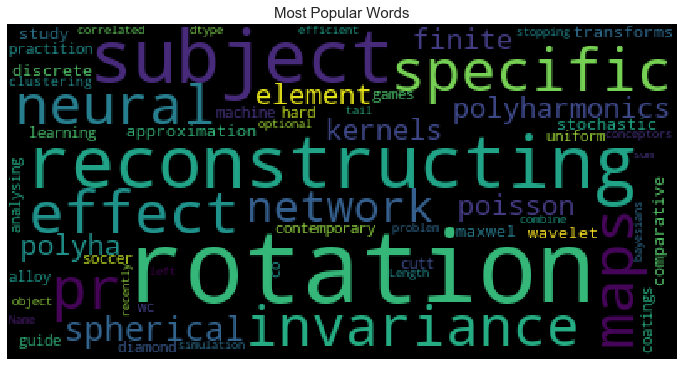

In [15]:
wordcloud = WordCloud(background_color = 'black').generate(str(train['combine']))
plt.rcParams['figure.figsize'] = (12, 8)
print(wordcloud)
plt.imshow(wordcloud)
plt.title('Most Popular Words', fontsize = 15)
plt.axis('off')
plt.show()

# Train and Validation split

In [16]:
binary_labels=train[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']]

# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(train['combine'], binary_labels, test_size=0.2, random_state=9)

# TF-IDF Vectorizer


In [18]:
svc = LinearSVC(C=0.8, penalty='l2', class_weight='balanced', loss='hinge',random_state=9,dual=True)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(svc))])
parameters = {
    'tfidf__max_df': np.arange(0.7,1,0.1),
    'tfidf__min_df' : np.arange(0,0.3,0.025),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features' : [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000,None]
    
}

fold=KFold(random_state=9,shuffle=True,n_splits=10)
grid_search_tune = RandomizedSearchCV(pipeline, parameters, cv=fold, n_jobs=-1,random_state=9,n_iter=100)
grid_search_tune.fit(xtrain, ytrain)

print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps) 

Best parameters set:
[('tfidf', TfidfVectorizer(max_df=0.9999999999999999, max_features=45000, min_df=0.0,
                ngram_range=(1, 3))), ('clf', OneVsRestClassifier(estimator=LinearSVC(C=0.8, class_weight='balanced',
                                        loss='hinge', random_state=9)))]


In [19]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9999999999999999,min_df=0.0, ngram_range=(1, 3),max_features=45000)

# create TF-IDF features
# TF-IDF = Term frequency - inverse document frequency
# Used to predict how important a word is for a document
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

# Model Building

Logistic Regression

In [20]:
#Run Logistic Regrssion
logreg = LogisticRegression(class_weight='balanced',n_jobs=-1,random_state=9)
logreg_classifier = OneVsRestClassifier(logreg)

# fit model on train data
logreg_classifier.fit(xtrain_tfidf, ytrain)

# make predictions
ytrain_pred=logreg_classifier.predict(xtrain_tfidf)
yval_pred = logreg_classifier.predict(xval_tfidf)

# evaluate performance
logreg_train_f1 = f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro')
logreg_test_f1 =f1_score(y_true=yval, y_pred=yval_pred, average='micro')

print('f1-Score Train: ',logreg_train_f1)
print('f1-Score validation: ',logreg_test_f1)

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

f1-Score Train:  0.8920740856867708
f1-Score validation:  0.8299945858148349


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.81      0.91      0.86      1704
             Physics       0.90      0.87      0.89      1211
         Mathematics       0.78      0.88      0.83      1089
          Statistics       0.72      0.87      0.79      1069
Quantitative Biology       0.41      0.65      0.50       116
Quantitative Finance       0.58      0.82      0.68        44

           micro avg       0.79      0.88      0.83      5233
           macro avg       0.70      0.83      0.76      5233
        weighted avg       0.79      0.88      0.83      5233
         samples avg       0.83      0.90      0.84      5233



In [21]:
# Cross-val score of train data using Logistic Regression model
logreg = LogisticRegression(class_weight='balanced',n_jobs=-1,random_state=9)
logreg_classifier = OneVsRestClassifier(logreg)
fold=KFold(n_splits=10,shuffle=True,random_state=9)
logreg_score=cross_val_score(logreg_classifier,xtrain_tfidf, ytrain,scoring='f1_micro',cv=fold,n_jobs=-1)

print('Score: ',logreg_score)

print('\n')

print("f1_score: %0.2f (+/- %0.2f)" % (logreg_score.mean(), logreg_score.std() * 2))

Score:  [0.82559199 0.82750846 0.82988871 0.83356196 0.82468124 0.81417927
 0.8100471  0.82675737 0.82923497 0.82690542]


f1_score: 0.82 (+/- 0.01)


Hyperparameter tuning Logistic Regression

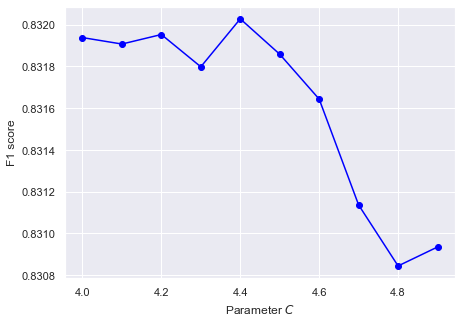

In [22]:
# For finding the best parameter
def train_classifier(X_train, y_train, X_valid=None, y_valid=None, C=1.0, model='lr'):
    """
      xtrain_tfidf, ytrain — training data
      return: trained classifier
      
    """   
    if model=='lr':
        model = LogisticRegression(C=C, penalty='l2', dual=False, solver='liblinear',random_state=9,class_weight='balanced')
        model = OneVsRestClassifier(model)
        model.fit(xtrain_tfidf, ytrain)

    return model

# plot
hypers = np.arange(4,5, 0.1)
res = []

for h in hypers:
    temp_model = train_classifier(xtrain_tfidf, ytrain, C=h, model='lr')
    temp_pred = f1_score(yval, temp_model.predict(xval_tfidf), average='micro')
    res.append(temp_pred)

plt.figure(figsize=(7,5))
plt.plot(hypers, res, color='blue', marker='o')
plt.grid(True)
plt.xlabel('Parameter $C$')
plt.ylabel('F1 score')
plt.show()

In [23]:
#Run Tuned Logistic Regrssion
logreg1 = LogisticRegression(class_weight='balanced',n_jobs=-1,random_state=9,C=4.4,solver='liblinear')
logreg1_classifier = OneVsRestClassifier(logreg1)

# fit model on train data
logreg1_classifier.fit(xtrain_tfidf, ytrain)

# make predictions
ytrain_pred=logreg1_classifier.predict(xtrain_tfidf)
yval_pred = logreg1_classifier.predict(xval_tfidf)

# evaluate performance
logreg1_train_f1 = f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro')
logreg1_test_f1 =f1_score(y_true=yval, y_pred=yval_pred, average='micro')

print('f1-Score Train: ',logreg1_train_f1)
print('f1-Score validation: ',logreg1_test_f1)

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

f1-Score Train:  0.9520374386485562
f1-Score validation:  0.832028010688289


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.82      0.90      0.86      1704
             Physics       0.91      0.87      0.89      1211
         Mathematics       0.80      0.87      0.83      1089
          Statistics       0.74      0.83      0.78      1069
Quantitative Biology       0.44      0.57      0.49       116
Quantitative Finance       0.62      0.80      0.70        44

           micro avg       0.80      0.86      0.83      5233
           macro avg       0.72      0.80      0.76      5233
        weighted avg       0.81      0.86      0.83      5233
         samples avg       0.84      0.89      0.84      5233



In [24]:
# Cross-val score of train data using tuned Logistic Regression model
logreg1 = LogisticRegression(class_weight='balanced',n_jobs=-1,random_state=9,C=4.4,solver='liblinear')
logreg1_classifier = OneVsRestClassifier(logreg1)
fold=KFold(n_splits=10,shuffle=True,random_state=9)
logreg1_score=cross_val_score(logreg1_classifier,xtrain_tfidf, ytrain,scoring='f1_micro',cv=fold,n_jobs=-1)

print('Score: ',logreg1_score)

print('\n')

print("f1_score: %0.2f (+/- %0.2f)" % (logreg1_score.mean(), logreg1_score.std() * 2))

Score:  [0.82901796 0.82983145 0.83700441 0.83356578 0.82391254 0.81868385
 0.80833524 0.82432119 0.83825925 0.82934834]


f1_score: 0.83 (+/- 0.02)


LinearSVC Classifier

In [25]:
#Run LinearSVC
svc = LinearSVC(class_weight='balanced',random_state=9)
svc_classifier = OneVsRestClassifier(svc)

# fit model on train data
svc_classifier.fit(xtrain_tfidf, ytrain)

# make predictions
ytrain_pred=svc_classifier.predict(xtrain_tfidf)
yval_pred = svc_classifier.predict(xval_tfidf)

# evaluate performance
svc_train_f1 = f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro')
svc_test_f1 =f1_score(y_true=yval, y_pred=yval_pred, average='micro')

print('f1-Score Train: ',svc_train_f1)
print('f1-Score validation: ',svc_test_f1)

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

f1-Score Train:  0.9854026570444481
f1-Score validation:  0.8271732010854309


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.82      0.88      0.85      1704
             Physics       0.91      0.86      0.88      1211
         Mathematics       0.81      0.86      0.83      1089
          Statistics       0.75      0.81      0.78      1069
Quantitative Biology       0.48      0.49      0.49       116
Quantitative Finance       0.73      0.75      0.74        44

           micro avg       0.81      0.84      0.83      5233
           macro avg       0.75      0.77      0.76      5233
        weighted avg       0.81      0.84      0.83      5233
         samples avg       0.84      0.87      0.83      5233



In [26]:
# Cross-val score of train data using LinearSVC model
svc = LinearSVC(class_weight='balanced',random_state=9)
svc_classifier = OneVsRestClassifier(svc)

fold=KFold(n_splits=10,shuffle=True,random_state=9)
svc_scores=cross_val_score(svc_classifier,xtrain_tfidf, ytrain,scoring='f1_micro',cv=fold,n_jobs=-1)

print(svc_scores)

print('\n')

print("f1_score: %0.2f (+/- %0.2f)" % (svc_scores.mean(), svc_scores.std() * 2))

[0.82280577 0.81809658 0.8260355  0.83070403 0.81749409 0.80617255
 0.80345472 0.8194248  0.83238905 0.82514828]


f1_score: 0.82 (+/- 0.02)


Hyperperameter Tuniing LinearSVC

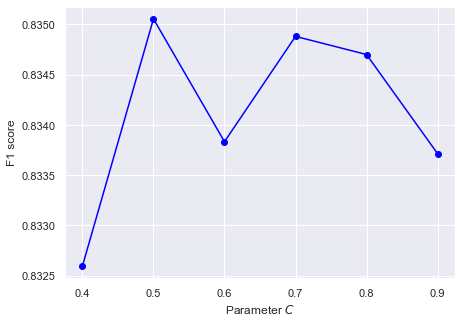

In [27]:
# For finding the best parameter
def train_classifier(X_train, y_train, X_valid=None, y_valid=None, C=1.0, model='svm'):
    """
      xtrain_tfidf, ytrain — training data
      return: trained classifier
      
    """
    if model=='svm':
        model = LinearSVC(C=C, penalty='l2', class_weight='balanced', loss='hinge',random_state=9,dual=True)
        model = OneVsRestClassifier(model)
        model.fit(xtrain_tfidf, ytrain)

    return model

# plot
hypers = np.arange(0.4,1, 0.1)
res = []

for h in hypers:
    temp_model = train_classifier(xtrain_tfidf, ytrain, C=h, model='svm')
    temp_pred = f1_score(yval, temp_model.predict(xval_tfidf), average='micro')
    res.append(temp_pred)

plt.figure(figsize=(7,5))
plt.plot(hypers, res, color='blue', marker='o')
plt.grid(True)
plt.xlabel('Parameter $C$')
plt.ylabel('F1 score')
plt.show()

In [28]:
#Run Tuned Linear SVC
svc1 = LinearSVC(C=0.5, penalty='l2', class_weight='balanced', loss='hinge',random_state=9,dual=True)
svc1_classifier = OneVsRestClassifier(svc1)

# fit model on train data
svc1_classifier.fit(xtrain_tfidf, ytrain)

# make predictions
ytrain_pred=svc1_classifier.predict(xtrain_tfidf)
yval_pred = svc1_classifier.predict(xval_tfidf)

# evaluate performance
svc1_train_f1 = f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro')
svc1_test_f1 =f1_score(y_true=yval, y_pred=yval_pred, average='micro')

print('f1-Score Train: ',svc1_train_f1)
print('f1-Score validation: ',svc1_test_f1)

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

f1-Score Train:  0.9103343124285298
f1-Score validation:  0.8350552836686606


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.81      0.92      0.86      1704
             Physics       0.91      0.87      0.89      1211
         Mathematics       0.78      0.88      0.83      1089
          Statistics       0.72      0.88      0.79      1069
Quantitative Biology       0.44      0.53      0.48       116
Quantitative Finance       0.67      0.75      0.71        44

           micro avg       0.79      0.88      0.84      5233
           macro avg       0.72      0.80      0.76      5233
        weighted avg       0.80      0.88      0.84      5233
         samples avg       0.83      0.90      0.85      5233



In [29]:
# Cross-val score of train data using tuned LinearSVC model
svc1 = LinearSVC(C=0.5, penalty='l2', class_weight='balanced', loss='hinge',random_state=9,dual=True)
svc1_classifier = OneVsRestClassifier(svc1)

fold=KFold(n_splits=10,shuffle=True,random_state=9)
svc1_scores=cross_val_score(svc1_classifier,xtrain_tfidf, ytrain,scoring='f1_micro',cv=fold,n_jobs=-1)

print(svc1_scores)

print('\n')

print("f1_score: %0.2f (+/- %0.2f)" % (svc1_scores.mean(), svc1_scores.std() * 2))

[0.82619647 0.82902494 0.83416629 0.83657143 0.82656321 0.8185502
 0.81300448 0.82638259 0.83398036 0.83513451]


f1_score: 0.83 (+/- 0.01)


SGDClassifier

In [30]:
#Run SGD Classifier
sgd = SGDClassifier(random_state=9,class_weight='balanced',n_jobs=-1,alpha=0.0001,loss='hinge')
sgd_classifier = OneVsRestClassifier(sgd)

# fit model on train data
sgd_classifier.fit(xtrain_tfidf, ytrain)

# make predictions
ytrain_pred=sgd_classifier.predict(xtrain_tfidf)
yval_pred = sgd_classifier.predict(xval_tfidf)


# evaluate performance
sgd_train_f1 = f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro')
sgd_test_f1 =f1_score(y_true=yval, y_pred=yval_pred, average='micro')

print('f1-Score Train: ',sgd_train_f1)
print('f1-Score validation: ',sgd_test_f1)

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

f1-Score Train:  0.9153096651360735
f1-Score validation:  0.8337092844897591


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.81      0.92      0.86      1704
             Physics       0.91      0.87      0.89      1211
         Mathematics       0.78      0.88      0.82      1089
          Statistics       0.72      0.88      0.79      1069
Quantitative Biology       0.43      0.57      0.49       116
Quantitative Finance       0.63      0.84      0.72        44

           micro avg       0.79      0.88      0.83      5233
           macro avg       0.71      0.83      0.76      5233
        weighted avg       0.80      0.88      0.84      5233
         samples avg       0.83      0.91      0.85      5233



In [31]:
# Cross-val score of train data using SGD Classifier model
sgd = SGDClassifier(random_state=9,class_weight='balanced',n_jobs=-1,alpha=0.0001,loss='hinge')
sgd_classifier = OneVsRestClassifier(sgd)

fold=KFold(n_splits=10,shuffle=True,random_state=9)
sgd_scores=cross_val_score(sgd_classifier,xtrain_tfidf, ytrain,scoring='f1_micro',cv=fold,n_jobs=-1)

print(sgd_scores)

print('\n')

print("f1_score: %0.2f (+/- %0.2f)" % (sgd_scores.mean(), sgd_scores.std() * 2))

[0.82690542 0.82917988 0.83423913 0.83658033 0.82398541 0.82031603
 0.81390135 0.82195509 0.83785633 0.8353211 ]


f1_score: 0.83 (+/- 0.02)


# Bagging Classifier

Bagged Logistic Regression

In [32]:
#Run bagged logistic regression
lr = LogisticRegression(class_weight='balanced',n_jobs=-1,random_state=9,C=4.4,solver='liblinear')
lr_bag=BaggingClassifier(base_estimator=lr,random_state=9,n_jobs=-1)
lr_bag_classifier = OneVsRestClassifier(lr_bag)

# fit model on train data
lr_bag_classifier.fit(xtrain_tfidf, ytrain)

# make predictions
ytrain_pred = lr_bag_classifier.predict(xtrain_tfidf)
yval_pred = lr_bag_classifier.predict(xval_tfidf)

# evaluate performance
lr_bagged_train_f1 = f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro')
lr_bagged_test_f1 =f1_score(y_true=yval, y_pred=yval_pred, average='micro')

print('f1-Score Train: ',lr_bagged_train_f1)
print('f1-Score validation: ',lr_bagged_test_f1)

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

f1-Score Train:  0.9295117557392951
f1-Score validation:  0.8328971962616822


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.82      0.89      0.85      1704
             Physics       0.92      0.86      0.89      1211
         Mathematics       0.81      0.85      0.83      1089
          Statistics       0.75      0.82      0.79      1069
Quantitative Biology       0.48      0.52      0.50       116
Quantitative Finance       0.67      0.75      0.71        44

           micro avg       0.82      0.85      0.83      5233
           macro avg       0.74      0.78      0.76      5233
        weighted avg       0.82      0.85      0.83      5233
         samples avg       0.84      0.88      0.84      5233



In [33]:
# Cross-val score of train data using Bagged Logistic Regression model
lr = LogisticRegression(class_weight='balanced',n_jobs=-1,random_state=9,C=4.4,solver='liblinear')
lr_bag=BaggingClassifier(base_estimator=lr,random_state=9,n_jobs=-1)
lr_bag_classifier = OneVsRestClassifier(lr_bag)

fold=KFold(n_splits=10,shuffle=True,random_state=9)
lr_bag_score=cross_val_score(lr_bag_classifier,xtrain_tfidf, ytrain,scoring='f1_micro',cv=fold,n_jobs=-1)

print('Score: ',lr_bag_score)

print('\n')

print("f1_score: %0.2f (+/- %0.2f)" % (lr_bag_score.mean(), lr_bag_score.std() * 2))

Score:  [0.82890995 0.83024184 0.83144476 0.83565197 0.82210626 0.81705317
 0.81086099 0.82617875 0.83652709 0.82944259]


f1_score: 0.83 (+/- 0.02)


LinearSVC baged

In [34]:
#Run bagged LinearSVC
svc = LinearSVC(C=0.5, penalty='l2', class_weight='balanced', loss='hinge',random_state=9,dual=True)
svc_bag=BaggingClassifier(base_estimator=svc,random_state=9,n_jobs=-1)
svc_bag_classifier = OneVsRestClassifier(svc_bag)

# fit model on train data
svc_bag_classifier.fit(xtrain_tfidf, ytrain)

# make predictions
ytrain_pred = svc_bag_classifier.predict(xtrain_tfidf)
yval_pred = svc_bag_classifier.predict(xval_tfidf)

# evaluate performance
svc_bagged_train_f1 = f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro')
svc_bagged_test_f1 =f1_score(y_true=yval, y_pred=yval_pred, average='micro')

print('f1-Score Train: ',svc_bagged_train_f1)
print('f1-Score validation: ',svc_bagged_test_f1)

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

f1-Score Train:  0.9188561011735217
f1-Score validation:  0.8359729554505881


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.81      0.91      0.86      1704
             Physics       0.92      0.86      0.89      1211
         Mathematics       0.80      0.86      0.83      1089
          Statistics       0.75      0.85      0.79      1069
Quantitative Biology       0.49      0.43      0.46       116
Quantitative Finance       0.78      0.66      0.72        44

           micro avg       0.81      0.86      0.84      5233
           macro avg       0.76      0.76      0.76      5233
        weighted avg       0.81      0.86      0.84      5233
         samples avg       0.84      0.89      0.84      5233



In [35]:
# Cross-val score of train data using Bagged LinearSVC model
svc = LinearSVC(C=0.5, penalty='l2', class_weight='balanced', loss='hinge',random_state=9,dual=True)
svc_bag=BaggingClassifier(base_estimator=svc,random_state=9,n_jobs=-1)
svc_bag_classifier = OneVsRestClassifier(svc_bag)

fold=KFold(n_splits=10,shuffle=True,random_state=9)
svc_bag_scores=cross_val_score(svc_bag_classifier,xtrain_tfidf, ytrain,scoring='f1_micro',cv=fold,n_jobs=-1)

print(svc_bag_scores)

print('\n')

print("f1_score: %0.2f (+/- %0.2f)" % (svc_bag_scores.mean(), svc_bag_scores.std() * 2))

[0.82708529 0.83031989 0.8331394  0.83883041 0.82724719 0.82086796
 0.81413492 0.82846546 0.83699206 0.83211679]


f1_score: 0.83 (+/- 0.01)


SGDClassifier Bagged

In [36]:
#Run bagged SGD Classifier
sgd = SGDClassifier(random_state=9,class_weight='balanced',n_jobs=-1,alpha=0.0001,loss='hinge')
sgd_bag=BaggingClassifier(base_estimator=sgd,random_state=9,n_jobs=-1)
sgd_bag_classifier = OneVsRestClassifier(sgd_bag)

# fit model on train data
sgd_bag_classifier.fit(xtrain_tfidf, ytrain)

# make predictions
ytrain_pred=sgd_bag_classifier.predict(xtrain_tfidf)
yval_pred = sgd_bag_classifier.predict(xval_tfidf)

# evaluate performance
sgd_bagged_train_f1 = f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro')
sgd_bagged_test_f1 =f1_score(y_true=yval, y_pred=yval_pred, average='micro')

print('f1-Score Train: ',sgd_bagged_train_f1)
print('f1-Score validation: ',sgd_bagged_test_f1)

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

f1-Score Train:  0.9232134729176149
f1-Score validation:  0.8355317775112998


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.81      0.90      0.86      1704
             Physics       0.92      0.86      0.89      1211
         Mathematics       0.80      0.86      0.83      1089
          Statistics       0.75      0.85      0.80      1069
Quantitative Biology       0.45      0.52      0.48       116
Quantitative Finance       0.63      0.82      0.71        44

           micro avg       0.81      0.87      0.84      5233
           macro avg       0.73      0.80      0.76      5233
        weighted avg       0.81      0.87      0.84      5233
         samples avg       0.84      0.89      0.85      5233



In [37]:
# Cross-val score of train data using Bagged SGD Classifier model
sgd = SGDClassifier(random_state=9,class_weight='balanced',n_jobs=-1,alpha=0.0001,loss='hinge')
sgd_bag=BaggingClassifier(base_estimator=sgd,random_state=9,n_jobs=-1)
sgd_bag_classifier = OneVsRestClassifier(sgd_bag)

fold=KFold(n_splits=10,shuffle=True,random_state=9)
sgd_bag_scores=cross_val_score(sgd_bag_classifier,xtrain_tfidf, ytrain,scoring='f1_micro',cv=fold,n_jobs=-1)

print(sgd_bag_scores)

print('\n')

print("f1_score: %0.2f (+/- %0.2f)" % (sgd_bag_scores.mean(), sgd_bag_scores.std() * 2))

[0.83021515 0.83140343 0.83406823 0.83873979 0.82687821 0.81935484
 0.81420389 0.82694541 0.83668694 0.83282389]


f1_score: 0.83 (+/- 0.01)


# Models Summery

In [38]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Tuned Logistic Regression', 'Linear SVC','Tuned Linear SVC','SGD Classifier', 
              'Bagged Logistic Regression','Bagged Linear SVC','Bagged SGD Classifier'],
              
    'Train F1 Score': [logreg_train_f1, logreg1_train_f1, svc_train_f1, svc1_train_f1, sgd_train_f1,
                        lr_bagged_train_f1, svc_bagged_train_f1, sgd_bagged_train_f1 ],
    
    'Test F1 Score': [logreg_test_f1, logreg1_test_f1, svc_test_f1, svc1_test_f1, sgd_test_f1,
                        lr_bagged_test_f1, svc_bagged_test_f1, sgd_bagged_test_f1 ],
    
    'Cross-val F1_Score': [logreg_score.mean(), logreg1_score.mean(), svc_scores.mean(), svc1_scores.mean(), sgd_scores.mean(),
                        lr_bag_score.mean(), svc_bag_scores.mean(), sgd_bag_scores.mean() ],
    
    'F1_Score std': [logreg_score.std(), logreg1_score.std(), svc_scores.std(), svc1_scores.std(), sgd_scores.std(),
                        lr_bag_score.std(), svc_bag_scores.std(), sgd_bag_scores.std() ]
    
   
            })

result = results.sort_values(by='Test F1 Score', ascending=False)
result = result.set_index('Model')
display(result)

,Train F1 Score,Test F1 Score,Cross-val F1_Score,F1_Score std
Model,,,,
Bagged Linear SVC,0.918856,0.835973,0.828920,0.006951
Bagged SGD Classifier,0.923213,0.835532,0.829132,0.007225
Tuned Linear SVC,0.910334,0.835055,0.827957,0.007220
SGD Classifier,0.915310,0.833709,0.828024,0.007592
Bagged Logistic Regression,0.929512,0.832897,0.826842,0.007676
Tuned Logistic Regression,0.952037,0.832028,0.827228,0.008493
Logistic Regression,0.892074,0.829995,0.824836,0.006848
Linear SVC,0.985403,0.827173,0.820173,0.009021


Conclusion: Bagged LinearSVC is performing well in this problem as it gives highest f1_score in unknown data and have least variance error

# Final Submition

In [39]:
X= train['combine']
X_test= test['combine']
y=binary_labels

# create TF-IDF features
# TF-IDF = Term frequency - inverse document frequency
# Used to predict how important a word is for a document
X = tfidf_vectorizer.fit_transform(X)
X_test = tfidf_vectorizer.transform(X_test)

In [40]:
svc_bag_classifier.fit(X,y)
y_pred = svc_bag_classifier.predict(X_test)

col=['ID','Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
submit_test = pd.concat([test['ID'],pd.DataFrame(y_pred)], axis=1)
submit_test.columns=col
submit_test.to_csv('sample_submission.csv', index=False)
submit_test


,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,1,0,0,0
...,...,...,...,...,...,...,...
8984,29957,1,0,0,0,0,0
8985,29958,1,0,1,0,0,0
8986,29959,0,0,0,0,1,0
8987,29960,0,0,0,1,0,0
